# Libraries

In [1]:
import sys
sys.path.append('C:/Users/Chi Nguyen/Desktop/breast-cancer-detection/pytorch/pytorch-image-models')
import timm

In [2]:
timm.__version__

'0.8.1dev0'

In [3]:
import os
import sys
import shutil
import cv2
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import timm

from tqdm.notebook import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from sklearn.metrics import f1_score
#from sklearn.model_selection import StratifiedGroupKFold

# Metric - Probabilistic F1

In [4]:
def probabilistic_f1(labels, predictions, beta=0.5):
    y_true_count = 0
    ctp = 0
    cfp = 0

    for idx in range(len(labels)):
        prediction = min(max(predictions[idx], 0), 1)
        if (labels[idx]):
            y_true_count += 1
            ctp += prediction
            cfp += 1 - prediction
        else:
            cfp += prediction

    beta_squared = beta * beta
    c_precision = ctp / (ctp + cfp)
    c_recall = ctp / y_true_count
    if (c_precision > 0 and c_recall > 0):
        result = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall)
        return result
    else:
        return 0

In [32]:
TRAIN_PATH = "C:/Users/Chi Nguyen/Desktop/breast-cancer-detection/train_images_processed_512"
TEST_PATH =  "C:/Users/Chi Nguyen\Desktop/breast-cancer-detection/test_images"

# Dataset

## Get and Undersample Data

In [6]:
# read raw file
df = pd.read_csv("C:/Users/Chi Nguyen/Desktop/breast-cancer-detection/train.csv")
# add image filename columns
df["img_name"] = df["patient_id"].astype(str) + "/" + df["image_id"].astype(str) + ".png"
# shuffle it
df = df.sample(frac=1).reset_index(drop=True)

# undersample according to the cancer patients since they are minority
undersample_amount = len(df[df["cancer"]==1])

dfnotcancer = df[df["cancer"]==0].sample(undersample_amount).reset_index(drop=True)
dfcancer = df[df["cancer"]==1].reset_index(drop=True)

# concat and then shuffle, reset index
dff = pd.concat([dfcancer, dfnotcancer]).sample(frac=1).reset_index(drop=True)

print(f"Old data shape is {df.shape} and new data shape is: {dff.shape}")

dff.head()

Old data shape is (54706, 15) and new data shape is: (2316, 15)


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,img_name
0,1,55755,640788258,R,MLO,45.0,1,1,0,0.0,0,D,49,False,55755/640788258.png
1,1,37234,200829673,L,MLO,59.0,0,0,0,0.0,0,C,49,True,37234/200829673.png
2,1,48544,741869197,L,CC,41.0,0,0,0,1.0,0,C,49,False,48544/741869197.png
3,1,6319,193260630,L,MLO,50.0,0,0,0,1.0,0,B,49,False,6319/193260630.png
4,2,14301,1727650730,L,CC,64.0,0,0,0,NaN,0,NaN,21,False,14301/1727650730.png


# Process Data - Cut the ROI

In [7]:
def img2roi(img, is_dicom=False):
    """
    Returns ROI area in other words 
    cuts the image to a desired one
    
    Because there are machine label tags,
    undesired details out of the breast image.
    """
    if not is_dicom:
        img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        
    img = np.array(img * 255, dtype = np.uint8)
    # Binarize the image
    bin_img = cv2.threshold(img, 20, 255, cv2.THRESH_BINARY)[1]

    # Make contours around the binarized image, keep only the largest contour
    contours, _ = cv2.findContours(bin_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contour = max(contours, key=cv2.contourArea)

    # Find ROI from largest contour
    ys = contour.squeeze()[:, 0]
    xs = contour.squeeze()[:, 1]
    roi =  img[np.min(xs):np.max(xs), np.min(ys):np.max(ys)]
    
    #print(f"Shape of ROI image: {roi.shape}")
    
    return roi

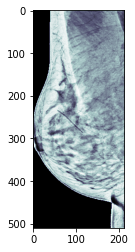

In [8]:
plt.imshow(img2roi(cv2.imread(TRAIN_PATH+"/"+dff.img_name[0])), cmap="bone")

# Augmentation

In [10]:
transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.2),
            transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
            transforms.RandomVerticalFlip(),
            transforms.RandomEqualize(),
            transforms.ToTensor()
        ])

# Create Dataset

In [11]:
class RSNADataset(Dataset):
    def __init__(self, df, img_folder, transform=transform, is_test=False):
        self.df = df
        self.img_folder = img_folder
        self.transform = transform
        self.is_test = is_test
    
    def __getitem__(self, idx):
        if self.is_test:
            dcm_path = os.path.join(self.img_folder, self.df["dcm_path"][idx])
            img = read_dicom(dcm_path)
            img = img2roi(img, is_dicom=True) 
            
            #print(img.shape)
        else:
            img_path = os.path.join(self.img_folder, self.df["img_name"][idx])
            img = cv2.imread(img_path)
            img = img2roi(img, is_dicom=False)
            
            #print(img.shape)
        img = cv2.resize(img, (224, 224))
        if self.transform is not None:
            img = self.transform(img)    
        img = torch.tensor(img, dtype=torch.float)
        #img = img.permute(2, 1, 0)
        if not self.is_test:
            target = self.df["cancer"][idx]
            target = torch.tensor(target, dtype=torch.float)
            return img, target
        img = img.unsqueeze(0)
        #print(img.shape)
        return img
    
    def __len__(self):
        return len(self.df)

# DataLoaders

In [12]:
split = .95
df = dff.sample(frac=1).reset_index(drop=True)
train_samples = int(len(df) * split)
train_df = df[:train_samples+1].reset_index(drop=True)
val_df = df[train_samples:].reset_index(drop=True)

train_dataset = RSNADataset(df=train_df, img_folder=TRAIN_PATH, transform=transform)
valid_dataset = RSNADataset(df=val_df, img_folder=TRAIN_PATH, transform=transform)
    
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(valid_dataset, batch_size=16, shuffle=True)

# Show Augmentations

In [13]:
def show_aug(inputs, targets, nrows=4, ncols=4, norm=False):
    plt.figure(figsize=(10, 10))
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    i_ = 0
    
    if len(inputs) > 25:
        inputs = inputs[:25]
        
    for idx in range(len(inputs)):
    
        # normalization
        if norm:           
            img = inputs[idx].numpy().transpose(1,2,0)
            mean = [0.485, 0.456, 0.406]
            std = [0.229, 0.224, 0.225] 
            img = (img*std+mean).astype(np.float32)
            
        else:
            img = inputs[idx].numpy().astype(np.float32)
            img = img[0,:,:]
        
        plt.subplot(nrows, ncols, i_+1)
        plt.title(f"Label: {targets[idx].item()}")
        plt.imshow(img, cmap="bone"); 
        plt.axis('off')
 
        i_ += 1
        
    return plt.show()

C:\Users\Chi Nguyen\miniconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


torch.Size([16, 1, 224, 224]) torch.Size([16])


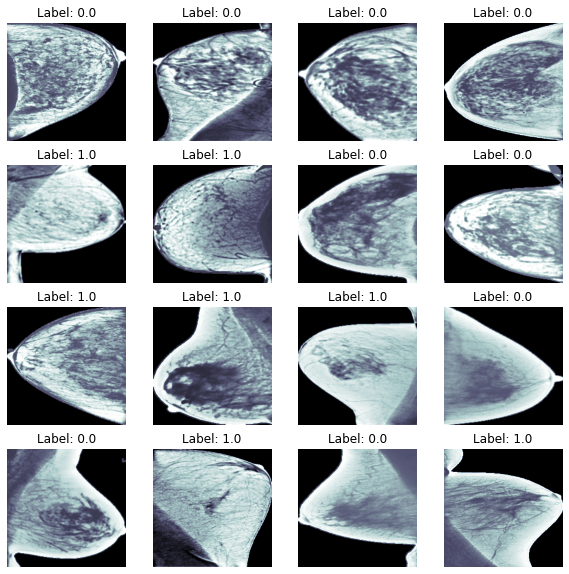

In [14]:
images, targets = next(iter(train_loader))
print(images.shape, targets.shape)

show_aug(images, targets)

C:\Users\Chi Nguyen\miniconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


torch.Size([16, 1, 224, 224]) torch.Size([16])


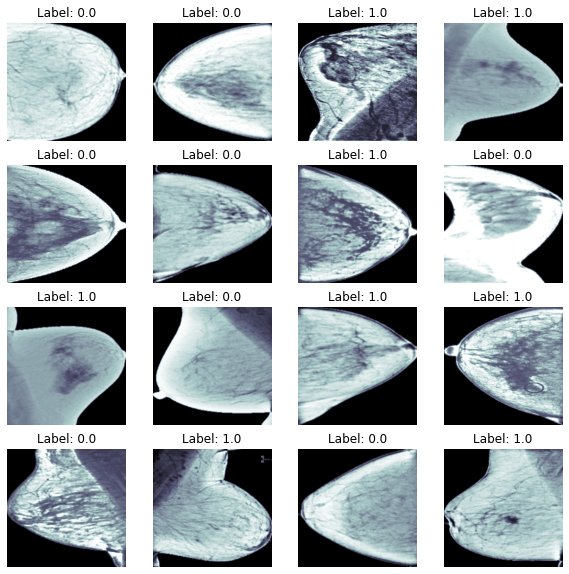

In [15]:
images, targets = next(iter(val_loader))
print(images.shape, targets.shape)

show_aug(images, targets)

# Model

In [16]:
class EfficientNetV2_xl(torch.nn.Module):
    def __init__(self, model_name="efficientnetv2_s",pretrained=False, out_dim=1):
        super().__init__()
        self.backbone = timm.create_model(model_name, pretrained=pretrained, in_chans=1)
        # adjust classifier
        self.backbone.classifier = nn.Linear(self.backbone.classifier.in_features, 
                             out_dim)
    def forward(self, x):
        return self.backbone(x)

In [17]:
EfficientNetV2_xl()

EfficientNetV2_xl(
  (backbone): EfficientNet(
    (conv_stem): Conv2d(1, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): ConvBnAct(
          (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNormAct2d(
            24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (drop_path): Identity()
        )
        (1): ConvBnAct(
          (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNormAct2d(
            24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inp

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [19]:
n_epochs = 15

In [20]:
def fit(model, epochs, train_loader, valid_loader, optimizer, loss_fn):
    
    train_loss, val_loss = [], []
    f1_score_hist = []
    
    for ep in tqdm(range(epochs+1)):
        print(f"{35*'='} Epoch:{ep+1} {35*'='}")
        model.train()
        
        running_loss = 0
        correct = 0
        total = 0
        # training
        for idx, (images, targets) in tqdm(enumerate(train_loader), total=len(train_loader)):
            images = images.to(device)
            targets = targets.to(device)
            
            outputs = model(images).view(-1)
            #targets = targets.unsqueeze(1)
            loss = loss_fn(outputs, targets.float())
            
                        
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            running_loss += loss.item()
            
            if idx % 100 == 0:
                print(f"Batch: {idx} | Train Batch Loss: {loss.item():.4f}")
        
        train_loss.append(running_loss / len(train_loader))
        
        print(f"\nEpoch: {ep+1} / {epochs} | Training Loss: {np.mean(train_loss):.4f}\n")
        
        
        # validation        
        all_outputs, all_targets = [], []
        correct_t = 0
        batch_loss = 0
        total_t = 0
        with torch.no_grad():
            #model.eval()
            for idx, (images_t, targets_t) in enumerate(valid_loader):
                images_t = images_t.to(device)
                targets_t = targets_t.to(device)
                
                outputs_t = model(images_t).view(-1)
                #targets_t = targets_t.unsqueeze(1)
                loss_t = loss_fn(outputs_t, targets_t.float())
                
                batch_loss += loss_t.item()
                
                if idx % 10 == 0:
                    print(f"\nBatch: {idx} | Valid Batch Loss: {loss_t.item():.4f}")
                
                all_outputs.extend(torch.sigmoid(outputs_t).cpu().detach().tolist())
                all_targets.extend(targets_t.cpu().detach().tolist())
        prob_f1_score = probabilistic_f1(all_targets, all_outputs)
        
        f1_score_hist.append(prob_f1_score)
        val_loss.append(batch_loss/len(val_loader))
        
        print(f"\nEpoch: {ep+1} / {epochs} | Validation Loss: {np.mean(val_loss):.4f}\n")
        print(f"\nF1 Score for Epoch {ep+1}: {prob_f1_score:.4f}\n")
                
        
    torch.save(model.state_dict(), "C:/Users/Chi Nguyen/Desktop/breast-cancer-detection/first.pth")
    
    return train_loss, val_loss, f1_score_hist

In [21]:
def run(train_loader, val_loader, epochs=n_epochs):
    model = EfficientNetV2_xl().to(device)
    
    optimizer = torch.optim.Adamax(params=model.parameters(), weight_decay=1e-2)
    loss_fn = nn.BCEWithLogitsLoss()
    
    train_loss, val_loss, f1_score_hist = fit(model=model, epochs=epochs, train_loader=train_loader,
        valid_loader=val_loader, optimizer=optimizer,
       loss_fn=loss_fn)
    return train_loss, val_loss, f1_score_hist

# Train the Model

In [22]:
train_loss, val_loss, f1_score_hist = run(train_loader, val_loader, n_epochs)

  0%|          | 0/16 [00:00<?, ?it/s]

=================================== Epoch:1 ===================================


  0%|          | 0/138 [00:00<?, ?it/s]

C:\Users\Chi Nguyen\miniconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Batch: 0 | Train Batch Loss: 0.6844
Batch: 100 | Train Batch Loss: 0.6450

Epoch: 1 / 15 | Training Loss: 0.7214


Batch: 0 | Valid Batch Loss: 0.7106

Epoch: 1 / 15 | Validation Loss: 0.6928


F1 Score for Epoch 1: 0.3418

=================================== Epoch:2 ===================================


  0%|          | 0/138 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.6769
Batch: 100 | Train Batch Loss: 0.6944

Epoch: 2 / 15 | Training Loss: 0.7093


Batch: 0 | Valid Batch Loss: 0.7049

Epoch: 2 / 15 | Validation Loss: 0.6964


F1 Score for Epoch 2: 0.3432

=================================== Epoch:3 ===================================


  0%|          | 0/138 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.7037
Batch: 100 | Train Batch Loss: 0.7266

Epoch: 3 / 15 | Training Loss: 0.7041


Batch: 0 | Valid Batch Loss: 0.6587

Epoch: 3 / 15 | Validation Loss: 0.6926


F1 Score for Epoch 3: 0.3374

=================================== Epoch:4 ===================================


  0%|          | 0/138 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.6812
Batch: 100 | Train Batch Loss: 0.7595

Epoch: 4 / 15 | Training Loss: 0.7021


Batch: 0 | Valid Batch Loss: 0.6964

Epoch: 4 / 15 | Validation Loss: 0.6935


F1 Score for Epoch 4: 0.3318

=================================== Epoch:5 ===================================


  0%|          | 0/138 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.7044
Batch: 100 | Train Batch Loss: 0.6821

Epoch: 5 / 15 | Training Loss: 0.7007


Batch: 0 | Valid Batch Loss: 0.6937

Epoch: 5 / 15 | Validation Loss: 0.6936


F1 Score for Epoch 5: 0.3321

=================================== Epoch:6 ===================================


  0%|          | 0/138 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.6948
Batch: 100 | Train Batch Loss: 0.6928

Epoch: 6 / 15 | Training Loss: 0.6996


Batch: 0 | Valid Batch Loss: 0.6950

Epoch: 6 / 15 | Validation Loss: 0.6938


F1 Score for Epoch 6: 0.3310

=================================== Epoch:7 ===================================


  0%|          | 0/138 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.6919
Batch: 100 | Train Batch Loss: 0.6951

Epoch: 7 / 15 | Training Loss: 0.6988


Batch: 0 | Valid Batch Loss: 0.6945

Epoch: 7 / 15 | Validation Loss: 0.6940


F1 Score for Epoch 7: 0.3309

=================================== Epoch:8 ===================================


  0%|          | 0/138 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.6950
Batch: 100 | Train Batch Loss: 0.6932

Epoch: 8 / 15 | Training Loss: 0.6981


Batch: 0 | Valid Batch Loss: 0.6937

Epoch: 8 / 15 | Validation Loss: 0.6940


F1 Score for Epoch 8: 0.3321

=================================== Epoch:9 ===================================


  0%|          | 0/138 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.6931
Batch: 100 | Train Batch Loss: 0.6959

Epoch: 9 / 15 | Training Loss: 0.6976


Batch: 0 | Valid Batch Loss: 0.6938

Epoch: 9 / 15 | Validation Loss: 0.6939


F1 Score for Epoch 9: 0.3322

=================================== Epoch:10 ===================================


  0%|          | 0/138 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.6932
Batch: 100 | Train Batch Loss: 0.6953

Epoch: 10 / 15 | Training Loss: 0.6971


Batch: 0 | Valid Batch Loss: 0.6926

Epoch: 10 / 15 | Validation Loss: 0.6939


F1 Score for Epoch 10: 0.3322

=================================== Epoch:11 ===================================


  0%|          | 0/138 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.6926
Batch: 100 | Train Batch Loss: 0.6942

Epoch: 11 / 15 | Training Loss: 0.6968


Batch: 0 | Valid Batch Loss: 0.6941

Epoch: 11 / 15 | Validation Loss: 0.6938


F1 Score for Epoch 11: 0.3320

=================================== Epoch:12 ===================================


  0%|          | 0/138 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.6936
Batch: 100 | Train Batch Loss: 0.6938

Epoch: 12 / 15 | Training Loss: 0.6965


Batch: 0 | Valid Batch Loss: 0.6932

Epoch: 12 / 15 | Validation Loss: 0.6938


F1 Score for Epoch 12: 0.3323

=================================== Epoch:13 ===================================


  0%|          | 0/138 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.6938
Batch: 100 | Train Batch Loss: 0.6929

Epoch: 13 / 15 | Training Loss: 0.6962


Batch: 0 | Valid Batch Loss: 0.6926

Epoch: 13 / 15 | Validation Loss: 0.6938


F1 Score for Epoch 13: 0.3322

=================================== Epoch:14 ===================================


  0%|          | 0/138 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.6926
Batch: 100 | Train Batch Loss: 0.6926

Epoch: 14 / 15 | Training Loss: 0.6960


Batch: 0 | Valid Batch Loss: 0.6921

Epoch: 14 / 15 | Validation Loss: 0.6938


F1 Score for Epoch 14: 0.3330

=================================== Epoch:15 ===================================


  0%|          | 0/138 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.6932
Batch: 100 | Train Batch Loss: 0.6915

Epoch: 15 / 15 | Training Loss: 0.6958


Batch: 0 | Valid Batch Loss: 0.6941

Epoch: 15 / 15 | Validation Loss: 0.6938


F1 Score for Epoch 15: 0.3328

=================================== Epoch:16 ===================================


  0%|          | 0/138 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.6923
Batch: 100 | Train Batch Loss: 0.6931

Epoch: 16 / 15 | Training Loss: 0.6956


Batch: 0 | Valid Batch Loss: 0.6941

Epoch: 16 / 15 | Validation Loss: 0.6939


F1 Score for Epoch 16: 0.3328



In [23]:
def plot_model_history(model_name,
                        train_history, val_history, 
                        num_epochs):
    
    x = np.arange(num_epochs)

    fig = plt.figure(figsize=(10, 6))
    plt.plot(x, train_history, label='train loss', lw=3, c="springgreen")
    plt.plot(x, val_history, label='validation loss', lw=3, c="deeppink")

    plt.title(f"{model_name}", fontsize=15)
    plt.legend(fontsize=12)
    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("DICE", fontsize=15)

    plt.show()

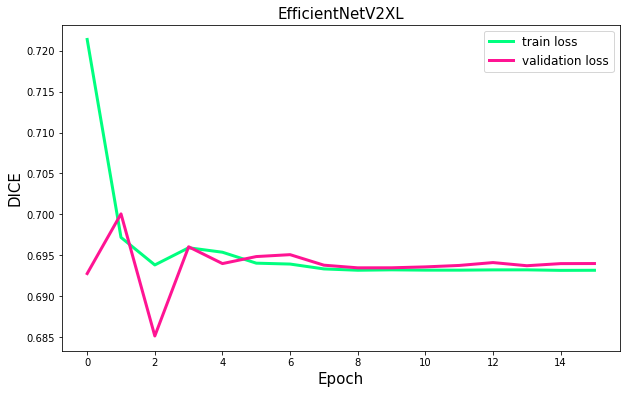

In [24]:
plot_model_history("EfficientNetV2XL", train_loss, val_loss, num_epochs=n_epochs+1)

# Submit

In [29]:
import dicomsdl

In [33]:
def read_dicom(path, fix_monochrome = True):
    dicom = dicomsdl.open(path)
    data = dicom.pixelData(storedvalue=True)  # storedvalue = True for int16 return otherwise float32
    data = data - np.min(data)
    data = data / np.max(data)
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = 1.0 - data
    return data

In [34]:
df_test = pd.read_csv("C:/Users/Chi Nguyen/Desktop/breast-cancer-detection/test.csv")
df_test["img_name"] = df_test["patient_id"].astype(str) + "/" + df_test["image_id"].astype(str) + ".png"
df_test["dcm_path"] = df_test["patient_id"].astype(str) + "/" + df_test["image_id"].astype(str) + ".dcm"

df_test.head()

,site_id,patient_id,image_id,laterality,view,age,implant,machine_id,prediction_id,img_name,dcm_path
0,2,10008,736471439,L,MLO,81,0,21,10008_L,10008/736471439.png,10008/736471439.dcm
1,2,10008,1591370361,L,CC,81,0,21,10008_L,10008/1591370361.png,10008/1591370361.dcm
2,2,10008,68070693,R,MLO,81,0,21,10008_R,10008/68070693.png,10008/68070693.dcm
3,2,10008,361203119,R,CC,81,0,21,10008_R,10008/361203119.png,10008/361203119.dcm


In [35]:
test_dataset=RSNADataset(df=df_test, img_folder=TEST_PATH, transform=None, is_test=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

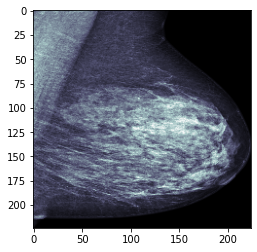

In [36]:
plt.imshow(next(iter(test_loader))[0][0], cmap="bone")

# Inference

In [37]:
for i in next(iter(test_loader)):
    print(i.shape)

torch.Size([1, 224, 224])
torch.Size([1, 224, 224])
torch.Size([1, 224, 224])
torch.Size([1, 224, 224])


In [46]:
def prediction_model(model, test_loader):    
    #model.eval()
    
    with torch.no_grad():
        preds = []
        if len(test_loader) != 1:
            # there are images and targets in loader in batches
            for images, targets in tqdm(test_loader, total=len(test_loader)):
                for im in tqdm(images):
                    pred = model(im.unsqueeze(0).float())
                    preds.append(pred)
        else:
            # just images
            for batch in tqdm(test_loader, total=len(test_loader)):
                for im in tqdm(batch):
                    pred = model(im.unsqueeze(0).float())
                    preds.append(pred)
            
        return torch.cat(preds).numpy()

In [47]:
preds = prediction_model(EfficientNetV2_xl(), test_loader)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [48]:
preds

array([[-0.08897847],
       [-0.09081601],
       [-0.08773924],
       [-0.08495697]], dtype=float32)

In [49]:
min_ = np.min(preds)
max_ = np.max(preds)

scaled_preds = []

for p in preds:
    new_p = (p - min_) / (max_ - min_)
    scaled_preds.append(new_p)
    
scaled_preds = np.array(scaled_preds)

In [50]:
scaled_preds

array([[0.31362462],
       [0.        ],
       [0.5251314 ],
       [1.        ]], dtype=float32)

In [51]:
sub_df = pd.read_csv("C:/Users/Chi Nguyen/Desktop/breast-cancer-detection/sample_submission.csv")
sub_df.head()

,prediction_id,cancer
0,10008_L,0.021168
1,10008_R,0.021168


In [52]:
prediction_id = df_test['patient_id'].astype(str) + "_" + df_test['laterality']
prediction_id

0    10008_L
1    10008_L
2    10008_R
3    10008_R
dtype: object

In [53]:
data = {"prediction_id": np.array(list((prediction_id))),
        "cancer": preds.T[0]
}

sub_df = pd.DataFrame(data=data)

In [54]:
subb = sub_df.drop_duplicates("prediction_id")
subb

,prediction_id,cancer
0,10008_L,-0.088978
2,10008_R,-0.087739
